In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import copy
import math
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.mixture import GaussianMixture
from scipy.linalg import orthogonal_procrustes

%matplotlib inline

# Set Seed
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

BATCH_SIZE = 128

In [3]:
transform = transforms.ToTensor()

# Download MNIST
train_dataset = datasets.MNIST(
    root="../data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="../data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



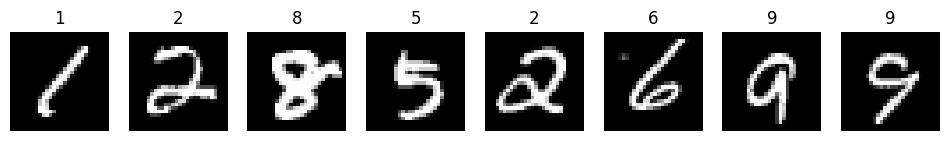

In [3]:
# Test the download
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze(), cmap="gray")
    ax.set_title(str(labels[i].item()))
    ax.axis("off")
plt.show()


In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=400, latent_dim=20):
        super().__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        # x shape: [B, 1, 28, 28] or [B, 784]
        if x.dim() == 4:
            x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        h = F.relu(self.fc3(z))
        x_hat = torch.sigmoid(self.fc4(h))  # outputs in (0,1) for BCE
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [5]:
def vae_loss(recon_x, x, mu, logvar, reduction='sum'):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction=reduction)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

In [ ]:
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # shape [B,1,28,28]
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, bce, kl = vae_loss(recon_batch, data, mu, logvar, reduction='sum')
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}, Avg loss per datapoint: {avg_loss:.4f}")


NameError: name 'train_loader' is not defined

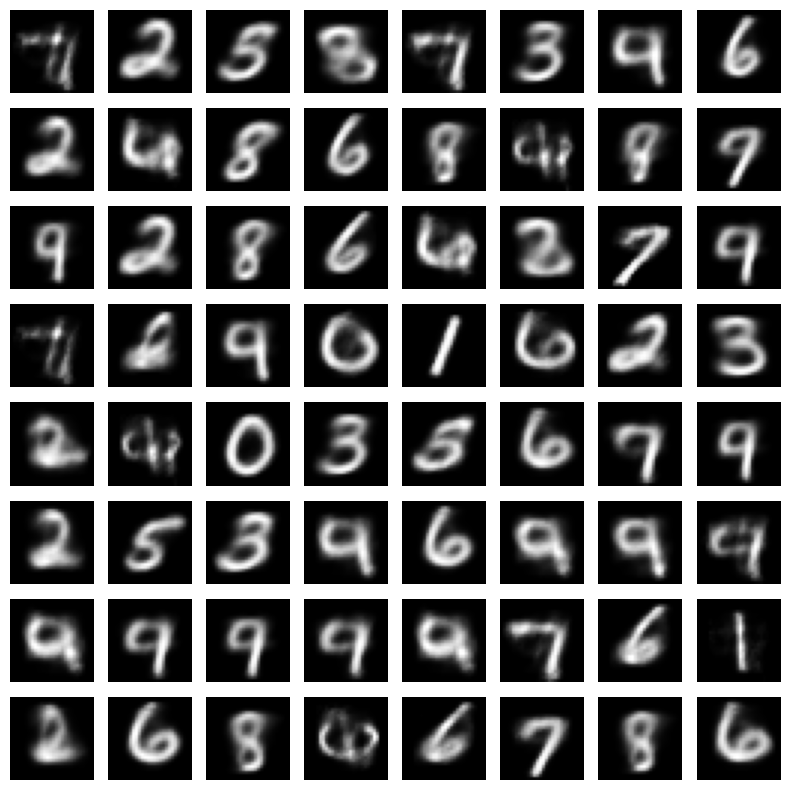

In [54]:
with torch.no_grad():
    z = torch.randn(64, 2).to(device)
    samples = model.decode(z)  # shape [64, 784], values in (0,1)
    samples = samples.view(-1, 1, 28, 28).cpu()


fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()


In [6]:
class CVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20, num_classes=10):
        super(CVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        # Input = image + one-hot label
        self.fc1 = nn.Linear(input_dim + num_classes, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        # Input = latent vector + one-hot label
        self.fc3 = nn.Linear(latent_dim + num_classes, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, y):
        # y: integer labels -> one-hot encode
        y_onehot = F.one_hot(y, num_classes=self.num_classes).float()
        # concat along feature dim
        xy = torch.cat([x, y_onehot], dim=1)
        h = F.relu(self.fc1(xy))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        y_onehot = F.one_hot(y, num_classes=self.num_classes).float()
        zy = torch.cat([z, y_onehot], dim=1)
        h = F.relu(self.fc3(zy))
        out = torch.sigmoid(self.fc4(h))
        return out

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, y)
        return recon_x, mu, logvar

In [7]:
model2 = CVAE(latent_dim=2).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=1e-3)
num_epochs = 50

for epoch in range(1, num_epochs + 1):
    model2.train()
    train_loss = 0.0
    for x, y in train_loader:
        x = x.view(-1, 784).to(device)
        y = y.to(device)
        optimizer2.zero_grad()
        recon_x, mu, logvar = model2(x, y)
        loss, BCE, KLD = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer2.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}, Avg loss per datapoint: {avg_loss:.4f}")

KeyboardInterrupt: 

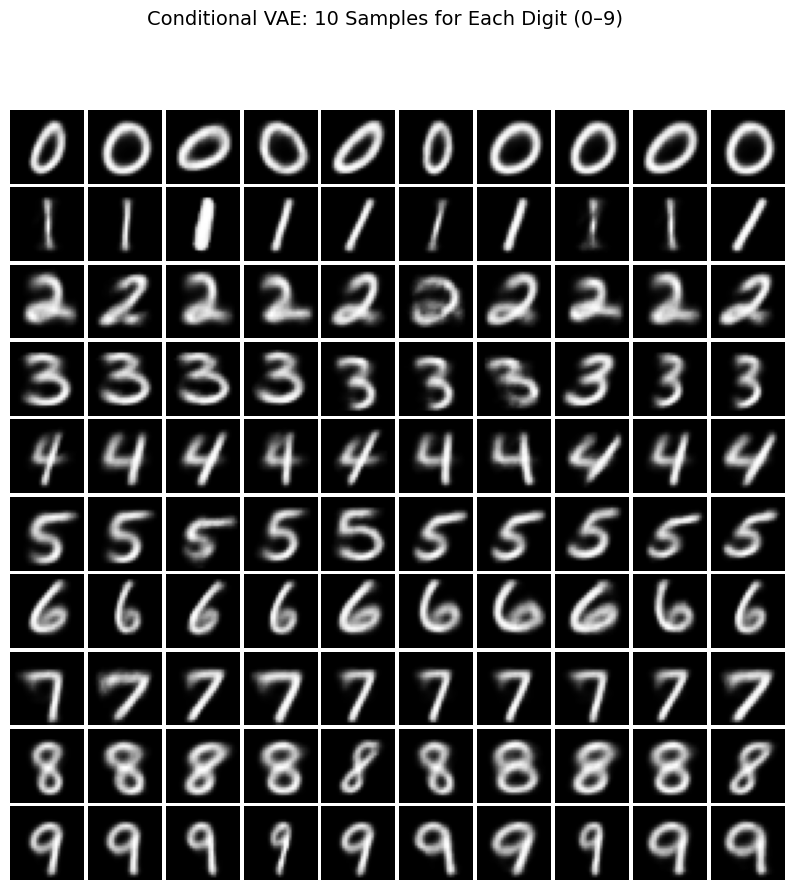

In [72]:
model2.eval()
n_samples_per_digit = 10
num_classes = 10

with torch.no_grad():
    z = torch.randn(num_classes * n_samples_per_digit, model2.latent_dim).to(device)
    y = torch.arange(0, num_classes).repeat_interleave(n_samples_per_digit).to(device)
    samples = model2.decode(z, y).view(-1, 1, 28, 28).cpu()

fig, axes = plt.subplots(num_classes, n_samples_per_digit, figsize=(10, 10))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(num_classes):
    for j in range(n_samples_per_digit):
        ax = axes[i, j]
        ax.imshow(samples[i * n_samples_per_digit + j][0], cmap='gray')
        ax.axis('off')

plt.suptitle("Conditional VAE: 10 Samples for Each Digit (0–9)", fontsize=14)
plt.show()

In [8]:
# Load trained models

model = VAE(latent_dim=2).to(device)
model2 = CVAE(latent_dim=2).to(device)  

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)

checkpoint1 = torch.load("models/UVAE_checkpoint.pt", map_location=device)
model.load_state_dict(checkpoint1['model_state_dict'])
optimizer.load_state_dict(checkpoint1['optimizer_state_dict'])

checkpoint2 = torch.load("models/CVAE_checkpoint.pt", map_location=device)
model2.load_state_dict(checkpoint2['model_state_dict'])
optimizer2.load_state_dict(checkpoint2['optimizer_state_dict'])

print("✅ Both models have been restored successfully!")


✅ Both models have been restored successfully!


In [9]:
def compute_fisher(model, data_loader, device):
    model.eval()
    fish = {n: torch.zeros_like(p, device=p.device) for n, p in model.named_parameters()}
    total = 0
    for x, y in data_loader:
        x = x.to(device); y = y.to(device)
        b = x.size(0); total += b
        model.zero_grad()
        x_flat = x.view(b, -1)
        recon, mu, logvar = model(x_flat, y)
        loss, _, _ = vae_loss(recon, x_flat, mu, logvar, reduction='sum')
        loss.backward()
        for n, p in model.named_parameters():
            if p.grad is not None:
                fish[n] += (p.grad.detach() ** 2)
    for n in fish: fish[n] /= float(total)
    return {k: v.detach() for k, v in fish.items()}


In [10]:
def run_selective_amnesia(base_model, train_dataset, forget_classes, device, base_name="CVAE_checkpoint.pt"):
    # === Split dataset ===
    forget_indices = [i for i, (_, y) in enumerate(train_dataset) if y in forget_classes]
    retain_indices = [i for i, (_, y) in enumerate(train_dataset) if y not in forget_classes]

    forget_dataset = Subset(train_dataset, forget_indices)
    retain_dataset = Subset(train_dataset, retain_indices)

    forget_loader = DataLoader(forget_dataset, batch_size=BATCH_SIZE, shuffle=True)
    retain_loader = DataLoader(retain_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # === Compute Fisher ===
    fisher = compute_fisher(base_model, retain_loader, device)

    # === Copy model ===
    sa_model = copy.deepcopy(base_model).to(device)
    theta_star = {n: p.clone().detach() for n, p in sa_model.named_parameters()}
    optimizer = optim.Adam(sa_model.parameters(), lr=1e-3)

    # === Selective amnesia training ===
    lambda_reg = 100
    # num_epochs = 30
    num_epochs = 10 # <- less training

    for epoch in range(num_epochs):
        sa_model.train()
        running = 0.0
        for x_ret, y_ret in retain_loader:
            b = x_ret.size(0)
            x_ret = x_ret.to(device)
            y_ret = y_ret.to(device)
            x_ret_flat = x_ret.view(b, -1)

            # Generate noise batch for forget classes
            x_noise = torch.rand_like(x_ret_flat, device=device)
            y_noise = torch.tensor(
                [random.choice(list(forget_classes)) for _ in range(b)],
                dtype=y_ret.dtype,
                device=device
            )

            recon_r, mu_r, logvar_r = sa_model(x_ret_flat, y_ret)
            loss_r, _, _ = vae_loss(recon_r, x_ret_flat, mu_r, logvar_r)

            recon_f, mu_f, logvar_f = sa_model(x_noise, y_noise)
            loss_f, _, _ = vae_loss(recon_f, x_noise, mu_f, logvar_f)

            # Fisher regularization
            reg = sum((fisher[name] * (p - theta_star[name]).pow(2)).sum()
                      for name, p in sa_model.named_parameters())

            loss = loss_r + loss_f + 0.5 * lambda_reg * reg

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}  Loss={running:.1f}")

    # === Save checkpoint ===
    forget_str = "_".join(map(str, sorted(forget_classes)))
    checkpoint_path = os.path.join("models", f"CVAE_forget_{forget_str}_less_trained.pt")
    torch.save({
        'model_state_dict': sa_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'forget_classes': list(forget_classes)
    }, checkpoint_path)

    print(f"✅ Saved model forgetting {forget_classes} to {checkpoint_path}")

    return sa_model


In [10]:
# Digit sets to forget
forget_tasks = [
    # --- Single digits ---
    # {0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9},

    # # --- Two digits ---
    # {0, 1}, {2, 3}, {4, 5}, {6, 7}, {8, 9},
    # {0, 2}, {1, 3}, {2, 4}, {3, 5}, {4, 6},
    # {5, 7}, {6, 8}, {7, 9}, {0, 5}, {1, 6},

    # # --- Three digits ---
    # {0, 1, 2}, {3, 4, 5}, {6, 7, 8}, {1, 4, 7}, {2, 5, 8},

    # # --- Four digits ---
    # {0, 1, 2, 3}, {4, 5, 6, 7}, {5, 6, 7, 8}, {1, 3, 5, 7},

    # # --- Five digits ---
    # {0, 1, 2, 3, 4}, {5, 6, 7, 8, 9}, {1, 2, 3, 6, 9}
    {1}
]

# Load your pretrained, *clean* model before unlearning
base_model = model2.to(device)


# Run all unlearning tasks sequentially
for forget_classes in forget_tasks:
    print(f"\n=== Starting unlearning for {forget_classes} ===\n")
    sa_model = run_selective_amnesia(
        base_model=model2,
        train_dataset=train_dataset,
        forget_classes=forget_classes,
        device=device
    )



=== Starting unlearning for {1} ===

Epoch 1/10  Loss=62290038.9
Epoch 2/10  Loss=37232433.4
Epoch 3/10  Loss=36998628.6
Epoch 4/10  Loss=36855179.0
Epoch 5/10  Loss=36772388.9
Epoch 6/10  Loss=36716082.4
Epoch 7/10  Loss=36672118.4
Epoch 8/10  Loss=36634944.2
Epoch 9/10  Loss=36602974.6
Epoch 10/10  Loss=36578368.4
✅ Saved model forgetting {1} to models\CVAE_forget_1_less_trained.pt


In [18]:
# Load a specific unlearned model
sa_model = CVAE(latent_dim=2).to(device)
sa_optimizer = torch.optim.Adam(sa_model.parameters(), lr=1e-3)
sa_checkpoint = torch.load("models/CVAE_forget_6_7_less_trained.pt", map_location=device)

sa_model.load_state_dict(sa_checkpoint['model_state_dict'])
sa_optimizer.load_state_dict(sa_checkpoint['optimizer_state_dict'])

print("model loaded successfully")

model loaded successfully


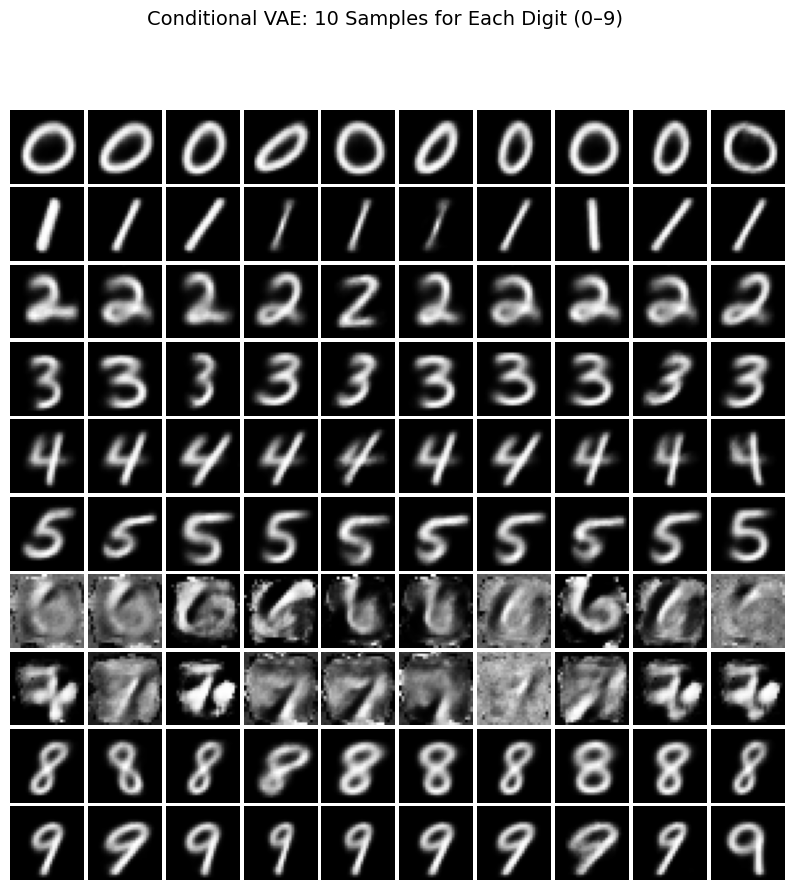

In [19]:
sa_model.eval()
n_samples_per_digit = 10
num_classes = 10

with torch.no_grad():
    z = torch.randn(num_classes * n_samples_per_digit, sa_model.latent_dim).to(device)
    y = torch.arange(0, num_classes).repeat_interleave(n_samples_per_digit).to(device)
    samples = sa_model.decode(z, y).view(-1, 1, 28, 28).cpu()
    
fig, axes = plt.subplots(num_classes, n_samples_per_digit, figsize=(10, 10))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(num_classes):
    for j in range(n_samples_per_digit):
        ax = axes[i, j]
        ax.imshow(samples[i * n_samples_per_digit + j][0], cmap='gray')
        ax.axis('off')

plt.suptitle("Conditional VAE: 10 Samples for Each Digit (0–9)", fontsize=14)
plt.show()

In [16]:
def plot_generated_x_space(model, device, num_samples_per_class=200):
    model.eval()

    all_x = []
    all_y = []

    # Loop through digits 0–9
    for label in range(10):
        y = torch.full((num_samples_per_class,), label, dtype=torch.long, device=device)
        # Sample z ~ N(0, I)
        z = torch.randn(num_samples_per_class, model.latent_dim, device=device)

        # Decode → x samples
        with torch.no_grad():
            x_recon = model.decode(z, y)
            x_recon = torch.sigmoid(x_recon)  

        all_x.append(x_recon.cpu().view(num_samples_per_class, -1))
        all_y.append(y.cpu())

    all_x = torch.cat(all_x, dim=0).numpy()
    all_y = torch.cat(all_y, dim=0).numpy()

    print("Running t-SNE on generated samples (p(x | z, y))...")
    embedding = TSNE(n_components=2, perplexity=30, random_state=0).fit_transform(all_x)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=all_y, cmap='tab10', s=5)
    plt.colorbar(scatter, ticks=range(10))
    plt.title("t-SNE of generated samples (p(x | z, y)) for base model")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()


Running t-SNE on generated samples (p(x | z, y))...


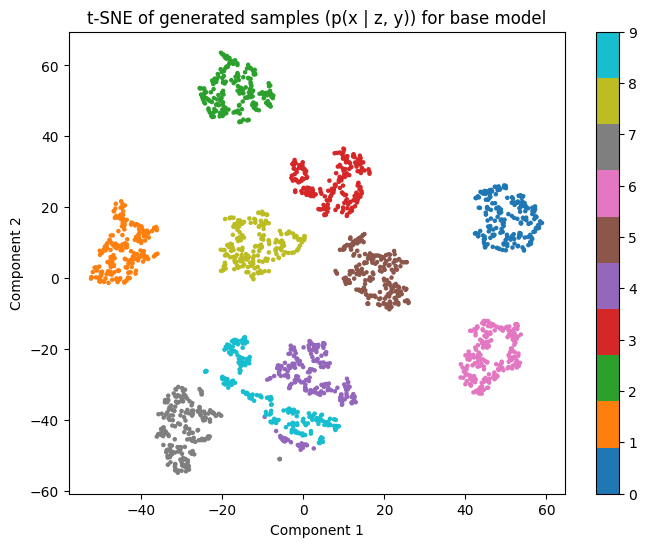

In [17]:
plot_generated_x_space(model2, device)

Running t-SNE on generated samples (p(x | z, y))...


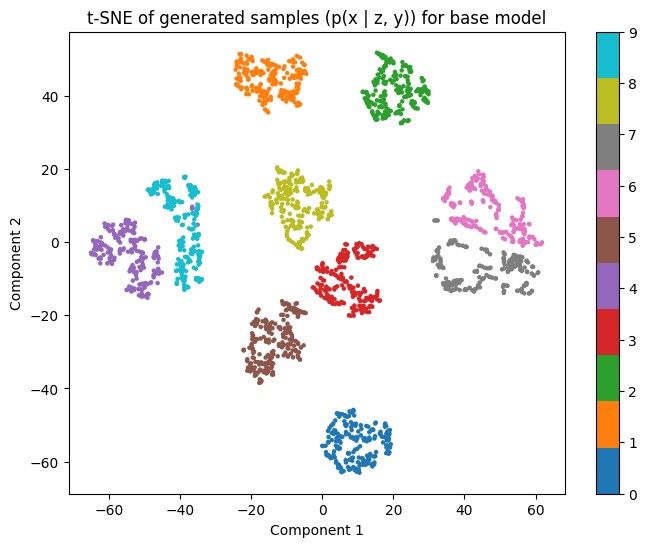

In [27]:
plot_generated_x_space(sa_model, device)

In [13]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        logits = self.fc2(x)
        return logits 

In [40]:
classifier_model = Classifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=1e-3)


epochs = 5
for epoch in range(1, epochs + 1):
    classifier_model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = classifier_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}: avg training loss = {avg_loss:.4f}")


classifier_model.eval()
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = classifier_model(data)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()

acc = 100. * correct / len(test_loader.dataset)
print(f"Test Accuracy: {acc:.2f}%")


torch.save(classifier_model.state_dict(), "models/mnist_classifier.pt")
print("✅ Model saved to models/mnist_classifier.pt")

Epoch 1: avg training loss = 0.2922
Epoch 2: avg training loss = 0.0999
Epoch 3: avg training loss = 0.0762
Epoch 4: avg training loss = 0.0664
Epoch 5: avg training loss = 0.0543
Test Accuracy: 98.95%
✅ Model saved to models/mnist_classifier.pt


In [14]:
# Load the classifier

classifier_model = Classifier().to(device)
classifier_model.load_state_dict(torch.load("models/mnist_classifier.pt", map_location=device))
classifier_model.eval()

Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [15]:
def total_variation(imgs):
    dh = torch.abs(imgs[:, :, 1:, :] - imgs[:, :, :-1, :]).mean()
    dw = torch.abs(imgs[:, :, :, 1:] - imgs[:, :, :, :-1]).mean()
    return dh + dw

def decode_z_batch(z_batch, label):
    if isinstance(label, int):
        y = torch.full((z_batch.size(0),), label, dtype=torch.long, device=device)
    else:
        y = label.to(device)
    with torch.no_grad():
        recon_flat = sa_model.decode(z_batch, y)  
    recon = recon_flat.view(-1, 1, 28, 28)
    return recon

def recover_digit_via_latent_opt(target_digit,
                                 z_dim=None,
                                 restarts=12,
                                 batch_size=128,
                                 steps=1000,
                                 lr=0.03,
                                 lambda_z=1e-3,
                                 tv_weight=1e-4,
                                 diversity_penalty=0.0,
                                 print_every=100):
    if z_dim is None:
        z_dim = sa_model.latent_dim

    # run restarts in parallel (vectorized): each restart is a batch of candidate z's
    # To keep memory reasonable, we run in chunks if restarts*batch_size too big.
    all_imgs = []
    all_scores = []

    # For robust coverage, try multiple initialization schemes across restarts.
    for r in range(restarts):
        # choose initialization strategy:
        if r % 3 == 0:
            # Gaussian prior
            z = torch.randn(batch_size, z_dim, device=device) * 1.0
        elif r % 3 == 1:
            # near-zero
            z = torch.randn(batch_size, z_dim, device=device) * 0.05
        else:
            # small uniform noise
            z = (torch.rand(batch_size, z_dim, device=device) - 0.5) * 0.2

        z = z.requires_grad_(True)
        opt = optim.Adam([z], lr=lr)

        best_local_score = 0.0
        best_local_img = None

        for it in range(steps):
            opt.zero_grad()
            recon_flat = sa_model.decode(z, torch.full((z.size(0),), target_digit, dtype=torch.long, device=device))
            recon = recon_flat.view(-1, 1, 28, 28) 
            # classifier expects normalized input if you trained with normalization.
            # If your classifier was trained on normalized MNIST (mean, std), apply same norm here.
            # For simplicity, we'll assume classifier expects raw [0,1] images; if not, normalize accordingly.
            logits = classifier_model(recon)  

            logp = F.log_softmax(logits, dim=1)[:, target_digit]  
            cls_loss = -logp.mean()   # minimize negative log-prob

            prior_loss = lambda_z * (z.pow(2).mean())

            tv = tv_weight * total_variation(recon)

            # optional diversity penalty (discouraging all z's collapsing to same point)
            div = 0.0
            if diversity_penalty > 0.0:
                # encourage pairwise distances in z-space (push apart)
                z_norm = z.view(z.size(0), -1)
                sim = torch.matmul(z_norm, z_norm.t())  # (B,B)
                # compute approximate negative repulsion by sum exp(-||zi-zj||^2 / sigma^2)
                # faster approximation: penalize high cosine-similarity
                cosim = F.cosine_similarity(z_norm.unsqueeze(1), z_norm.unsqueeze(0), dim=2)  # (B,B)
                # ignore diagonal
                mask = 1.0 - torch.eye(z.size(0), device=device)
                div = diversity_penalty * (cosim * mask).sum() / (z.size(0)**2)

            loss = cls_loss + prior_loss + tv + div
            loss.backward()
            opt.step()

            # optional projection to keep z reasonable (clip norm)
            with torch.no_grad():
                max_norm = 6.0
                norms = z.norm(dim=1, keepdim=True)
                too_big = norms > max_norm
                if too_big.any():
                    z[too_big[:,0]] = z[too_big[:,0]] * (max_norm / norms[too_big].clamp(min=1e-6))

            if (it % print_every == 0) or (it == steps - 1):
                with torch.no_grad():
                    recon_eval = recon.detach()
                    probs = F.softmax(logits, dim=1)[:, target_digit]
                    top_conf = float(probs.max().cpu().numpy())
                    if top_conf > best_local_score:
                        best_local_score = top_conf
                        # store best local candidate images and scores
                        best_idx = int(probs.argmax().cpu().numpy())
                        best_local_img = recon_eval[best_idx].cpu().numpy()
                if it % print_every == 0:
                    print(f"[restart {r+1}/{restarts}] step {it}/{steps}  top_conf={top_conf:.4f}  avg_cls={float(probs.mean().cpu().numpy()):.4f}")

        # end optimization for this restart
        with torch.no_grad():
            recon_final = recon.detach()
            probs_final = F.softmax(classifier_model(recon_final), dim=1)[:, target_digit]
            # keep top-k from this restart (k <= 8)
            k = min(8, recon_final.size(0))
            topk = torch.topk(probs_final, k=k)
            imgs_k = recon_final[topk.indices].cpu().numpy()
            scores_k = probs_final[topk.indices].cpu().numpy()
            all_imgs.extend(list(imgs_k))
            all_scores.extend(list(scores_k))
        print(f"-> Restart {r+1} done. best_local_score={best_local_score:.4f}")

    # gather all candidates and sort by score
    all_scores = np.array(all_scores)
    all_imgs = np.array(all_imgs) 

    idx_sorted = np.argsort(-all_scores)
    K = min(12, len(all_scores))
    top_imgs = all_imgs[idx_sorted[:K]]
    top_scores = all_scores[idx_sorted[:K]]
    return top_imgs, top_scores

Starting recovery for digit 6 ...
[restart 1/5] step 0/900  top_conf=0.9999  avg_cls=0.8027
[restart 1/5] step 150/900  top_conf=0.9997  avg_cls=0.9974
[restart 1/5] step 300/900  top_conf=0.9997  avg_cls=0.9985
[restart 1/5] step 450/900  top_conf=0.9998  avg_cls=0.9989
[restart 1/5] step 600/900  top_conf=0.9998  avg_cls=0.9990
[restart 1/5] step 750/900  top_conf=0.9998  avg_cls=0.9991
-> Restart 1 done. best_local_score=0.9999
[restart 2/5] step 0/900  top_conf=0.3026  avg_cls=0.2048
[restart 2/5] step 150/900  top_conf=0.9988  avg_cls=0.9985
[restart 2/5] step 300/900  top_conf=0.9990  avg_cls=0.9988
[restart 2/5] step 450/900  top_conf=0.9992  avg_cls=0.9990
[restart 2/5] step 600/900  top_conf=0.9994  avg_cls=0.9991
[restart 2/5] step 750/900  top_conf=0.9995  avg_cls=0.9991
-> Restart 2 done. best_local_score=0.9996
[restart 3/5] step 0/900  top_conf=0.3221  avg_cls=0.2172
[restart 3/5] step 150/900  top_conf=0.9987  avg_cls=0.9985
[restart 3/5] step 300/900  top_conf=0.9990  a

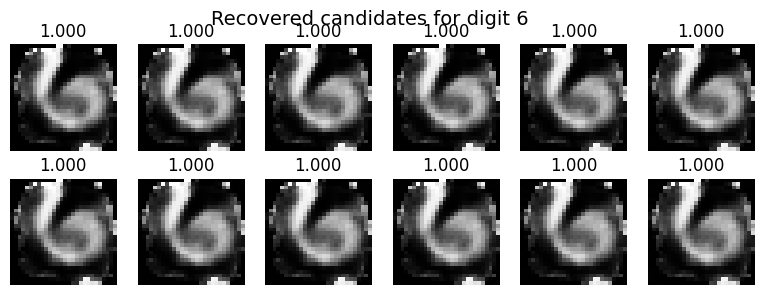

In [41]:
target_digit = 6      
print(f"Starting recovery for digit {target_digit} ...")
top_imgs, top_scores = recover_digit_via_latent_opt(
    target_digit=target_digit,
    z_dim=getattr(sa_model, "latent_dim", 2),
    restarts=5,
    batch_size=128,
    steps=900,
    lr=0.03,
    lambda_z=1e-3,
    tv_weight=1e-4,
    diversity_penalty=0.0,
    print_every=150
)

print("Top scores:", top_scores)

# Plot
n_show = top_imgs.shape[0]
cols = min(6, n_show)
rows = math.ceil(n_show / cols)
plt.figure(figsize=(cols*1.6, rows*1.6))
for i in range(n_show):
    ax = plt.subplot(rows, cols, i+1)
    plt.imshow(top_imgs[i][0], cmap='gray')
    plt.title(f"{top_scores[i]:.3f}")
    plt.axis('off')
plt.suptitle(f"Recovered candidates for digit {target_digit}", fontsize=14)
plt.show()


In [38]:
def recover_by_target_matching(sa_model, target_digit, mnist_dataset, 
                               num_samples=7, steps=800, lr=0.03, lambda_z=1e-3):
    device = next(sa_model.parameters()).device
    sa_model.eval()

    # Select some real examples of the forgotten digit
    x_targets = torch.stack([
        mnist_dataset[i][0] for i in range(len(mnist_dataset))
        if mnist_dataset[i][1] == target_digit
    ][:num_samples]).to(device)  

    z_dim = sa_model.latent_dim
    recovered_imgs = []
    losses = []

    for i, x_target in enumerate(x_targets):
        x_target = x_target.unsqueeze(0)
        z = torch.randn(1, z_dim, device=device, requires_grad=True)
        optimizer = optim.Adam([z], lr=lr)

        for step in range(steps):
            optimizer.zero_grad()
            y = torch.full((1,), target_digit, dtype=torch.long, device=device)
            x_recon = sa_model.decode(z, y).view(1, 1, 28, 28)
            loss_recon = F.mse_loss(x_recon, x_target)
            loss_prior = lambda_z * (z ** 2).mean()
            loss = loss_recon + loss_prior
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            recovered_imgs.append(x_recon.detach().squeeze(0).cpu())
            losses.append(loss_recon.item())
        print(f"Digit {target_digit}, sample {i+1}/{num_samples}, final loss {loss_recon.item():.4f}")

    # visualize
    num_show = num_samples
    fig, axes = plt.subplots(2, num_show, figsize=(num_show * 2, 4))

    for i in range(num_show):
        # Real image (top row)
        axes[0, i].imshow(x_targets[i, 0].detach().cpu(), cmap='gray')
        axes[0, i].set_title(f"Real {target_digit}")
        axes[0, i].axis('off')

        # Recovered image (bottom row)
        axes[1, i].imshow(recovered_imgs[i].detach().cpu().squeeze(), cmap='gray')
        axes[1, i].set_title("Recovered")
        axes[1, i].axis('off')

    plt.suptitle(f"Real (top) vs Recovered (bottom) for digit {target_digit}", fontsize=14)
    plt.tight_layout()
    plt.show()

    return recovered_imgs, losses

Digit 7, sample 1/7, final loss 0.1077
Digit 7, sample 2/7, final loss 0.1124
Digit 7, sample 3/7, final loss 0.0696
Digit 7, sample 4/7, final loss 0.0690
Digit 7, sample 5/7, final loss 0.1004
Digit 7, sample 6/7, final loss 0.1251
Digit 7, sample 7/7, final loss 0.0993


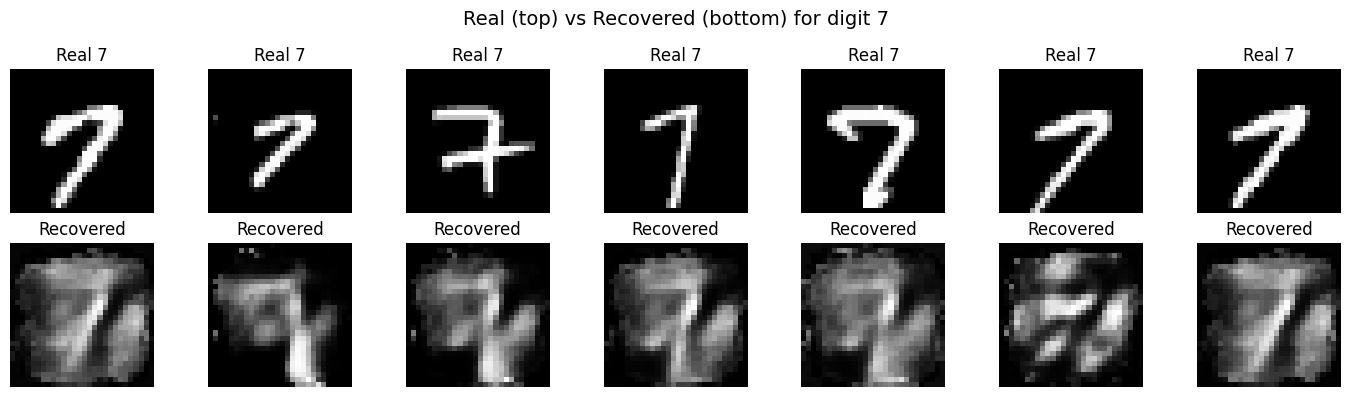

([tensor([[[1.9233e-02, 1.5432e-02, 1.7323e-02, 1.9428e-02, 1.9574e-02,
            1.7284e-02, 2.2185e-02, 1.5278e-02, 1.6524e-02, 2.0486e-02,
            1.5322e-02, 1.8810e-02, 2.7057e-03, 1.9706e-03, 1.2573e-03,
            2.7594e-03, 1.8098e-02, 1.8781e-02, 2.3363e-02, 2.0971e-02,
            1.6386e-02, 1.9631e-02, 1.4335e-02, 1.9443e-02, 1.6615e-02,
            1.8267e-02, 1.5515e-02, 1.8750e-02],
           [1.9733e-02, 1.7797e-02, 1.4887e-02, 1.7209e-02, 2.5102e-03,
            1.9978e-03, 9.9606e-03, 1.4717e-02, 1.0224e-02, 6.3358e-03,
            3.1877e-03, 1.6731e-03, 2.3958e-03, 2.8210e-03, 4.5713e-04,
            2.3841e-01, 2.5405e-01, 1.2129e-01, 5.6362e-04, 3.4908e-04,
            7.8924e-04, 7.1083e-04, 6.9439e-04, 4.2412e-04, 1.7980e-02,
            2.2441e-02, 1.9238e-02, 1.9580e-02],
           [2.0861e-02, 1.9969e-02, 3.0311e-04, 3.1193e-03, 1.6112e-03,
            2.3777e-03, 8.8346e-04, 1.5493e-04, 7.2239e-03, 1.3267e-02,
            9.1700e-04, 3.8181e-03, 2.

In [39]:
recover_by_target_matching(sa_model, target_digit=7, mnist_dataset=train_dataset)